# Tweet sentiment analysis

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import boto3
import s3fs
%matplotlib inline
plt.style.use('seaborn-dark')
pd.set_option('display.max_colwidth', -1)

## Get dataframe from S3 bucket
Iterates over all objects in the tweet-object folder in the aws s3 bucket.
The objects are retrieved in JSON format and converted to a Pandas dataframe.

In [2]:
# # Read CSV file
# #tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets{}.csv'.format(datetime.date.today()))
# tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets2019-10-08.csv')
# tweets_today = tweets_today.head(5000)
# # Gets tweet texts
# tweets_today_text = tweets_today['tweet']
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=('creation date','keyword', 'tweet', 
                                  'username'))
s3 = boto3.resource('s3')

s3_tweets = s3.Bucket(bucketname).objects.filter(Prefix='tweet-objects/', Delimiter='/').all()
for file in s3_tweets:
    temp_df = pd.read_json('s3://{}/{}'.format(bucketname, file.key))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True)
dataframe_tweets = dataframe['tweet']
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46152 entries, 0 to 46151
Data columns (total 4 columns):
creation date    46152 non-null object
keyword          46152 non-null object
tweet            46152 non-null object
username         46152 non-null object
dtypes: object(4)
memory usage: 1.4+ MB


## Data cleaning
Removing unneeded characters from the tweet texts like hashtags and urls

In [3]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=''
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', '', processed_word, flags=re.I)
        
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+' '+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
print('unprocessed tweet: \n'+ dataframe['tweet'][15])
print('\nprocessed tweet: \n' + tweets_text[15])

unprocessed tweet: 
AOC: My ‘Dreams of Motherhood Now Bittersweet’ Because of Global Warming https://t.co/uUIM3uSbTi https://t.co/WFLq78IywX

processed tweet: 
 aoc my dreams of motherhood now bittersweet because of global warming  


## Labeling tweets with NLTK vader
Provides te dataframe of the needed "label" / "target" column. In our case this column contains the sentiment values (Positive, Neutral, Negative)

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The NLTK.vader library helps us label the tweets by giving the tweet text a positive, neutral and negative score. Based on those scores it calculates the "compound" / "total" score. This is the value that gets stored in the dataframe 

In [5]:
sid = SentimentIntensityAnalyzer()

for i, tweet in enumerate(tweets_text[50:60]):
    print('{0}:{1} \n{2}\n\n'.format(i, tweet, sid.polarity_scores(tweet)))

0: climate change evidence how do we know gt vital signs of the planet global climate change and global warming how do we know its happening heres the evidence  
{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5994}


1: the election debate is over stay on the track libs mistakes in four years must not be hidden apologized snc lavalin climate change vs pipeline international relations economy down huge deficit list goes on never repeated libs must go say no to libs vote no  
{'neg': 0.219, 'neu': 0.738, 'pos': 0.044, 'compound': -0.8054}


2: revealed google made large contributions to climate change deniers  
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}


3: climate change the devastating effect plastics have on our oceans dwindling numbers of rare species nah  
{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6908}


4: pieces of junk toplevel japanese climate scientist rejects global warming panic  opinion  lifesite  
{'neg': 0.359, 'neu': 0.552, 'pos'

In [6]:
# Creates the text labels for the dataframe
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0:
        return 'neutral'
    else:
        return 'negative'

word_count = [len(tweet.split()) for tweet in dataframe_tweets]

polarity_tweets = [round(sid.polarity_scores(tweet)['compound'], 2)
                   for tweet in tweets_text]

sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_text, word_count, dataframe['keyword'],
                       dataframe['username'], dataframe['creation date']))


# Store to new dataframe with sentiment values and polarities
sentiment_df = pd.DataFrame(zipped_list, 
                            columns=['Sentiment', 'Polarity', 
                                     'Tweet', 'Word count', 'Keyword', 'Username', 
                                     'Creation Date'])
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46152 entries, 0 to 46151
Data columns (total 7 columns):
Sentiment        46152 non-null object
Polarity         46152 non-null float64
Tweet            46152 non-null object
Word count       46152 non-null int64
Keyword          46152 non-null object
Username         46152 non-null object
Creation Date    46152 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 2.5+ MB


In [7]:
sentiment_df.sample(15)

,Sentiment,Polarity,Tweet,Word count,Keyword,Username,Creation Date
6365,negative,-0.04,ok so if global warming doesnt take me out before then my retirement plan is to walk into the woods on my 65th birthday and do a lethal dose of heroin fin,32,Climate change,103ffcb50ad067f3770a798f23ddc295,2019-10-18 20:40:37
22930,positive,0.48,some good news for a change good on clover moore for a sensible decision to move us forward and for the climate nay sayers this will also drastically reduce pollution and we know what causing both problems,38,Climate change,97b34634d6ad220ac797ebc30e8abf6f,2019-10-24 09:41:23
12141,negative,-0.08,india is trying to deal with its coal addiction and the world has a lot to learn from its attempt india is highly vulnerable to climate change and yet more than half of its energy comes from burning coal lets replace dirty coal with clean canadian lng,47,Climate change,18126e7bd3f84b3f3e4df094def5b7de,2019-10-21 19:38:09
25856,negative,-0.34,rcmp finds alberta wildfires started by arson b ut hey lets blame climate change,15,Global warming,386057cf88fd13f17174356245dde26c,2019-10-24 22:50:12
41136,positive,0.40,cash for carbon schumer climate plan would help consumers buy electric cars the new york times,18,Climate change,52012725f6ce03ba6f2ff6c6be9fca05,2019-10-27 15:52:58
41959,neutral,0.00,a trial we will all be following this closely via npr,12,Climate change,7fe57f0e543525eabd65f40974f2ab23,2019-10-27 18:50:01
5961,neutral,0.00,the people of london have had it with the climate change activists calle via youtube,16,Climate change,aa592a2004e42c5668190066c89fb2de,2019-10-17 19:06:56
5978,negative,-0.38,doing my part in the fight against climate change by pledging to reduce my vegetable consumption to 0 by 2030,20,Climate change,b2613dc3994db697f5984a80369e8e0c,2019-10-17 19:06:13
222,positive,0.23,ok one day of cold was enough ill take that random 90 degree heatwave again thx climate change,19,Climate change,e606bbcead813f6d4b3f84d6d35b8583,2019-10-12 20:38:41
20446,positive,0.15,this whole week is literally in the 80s and yall still dont believe in global warming,17,Climate change,fee26bbdfe5ee3fd5214a5ab45547349,2019-10-23 22:40:16


In [8]:
print('5 most negative tweets: \n')
top5_negative = pd.DataFrame(sentiment_df.sort_values('Polarity')[['Tweet','Polarity']].head(5))
top5_negative

5 most negative tweets: 



,Tweet,Polarity
22660,capitalism is murder cyberbullying is murder minimum wage is murder billionaires existing is murder homicide is murder global warming is murder a group of crows is murder angela lansbury is murder she wrote,-0.99
3882,this is literally worse than isis terrorism racism homophobia sexism cancer global warming poverty world hunger israel war drug addiction the prison system police animal abuse pollution murder sexual abuse violence zionism depression mass shootings,-0.99
36659,breaking the law inciting riots breeding hate and violence endangering the lives of policecitizens is not cool you ignorant liberals its sedition its treason democrats are a terrorist cult and a danger to america,-0.98
40424,brainwashed idiots worried about so called climate change when were these fools ever worried about western regimes illegal wars destabilizing the middle east us missiles in poland civil wars spreading in europe no no ill worry about the weather,-0.98
38736,yes the unthinkable betrayal of the kurds separating children from parents at the border destroying family farms with stupid trade wars increasing the federal deficit pulling out of climate change pact only a few of the unthinkably stupid and careless acts of this moron,-0.98


In [9]:
print('5 most positive tweets: \n')
top5_positive = sentiment_df.sort_values('Polarity', ascending=False)[['Tweet', 'Polarity']].head(5)
top5_positive

5 most positive tweets: 



,Tweet,Polarity
26668,in ww2 the government rose taxes and kept wages down but the rich made big profits on armaments to fight climate change the rich are going to lose out on selling coal and oil they are prepared to chance the great famine to protect their wealth they will eat while you stave,0.98
41177,success takes many shapes and forms it can be a successful career your efforts to fight global warming writing a great book helping the homeless etc thrive success inspiration talent motivation,0.98
39530,happy diwali to all have fun have great food enjoy also dont forget that climate change is a real concern be safe and try your best to keep it environment friendly keep the animals safe its a festival for everyone lets not steal their freedom,0.98
14754,greswoldschool well done year 5 for the brilliant harvest festival assembly great message about climate change and doing our bit to save the planet super singing too very inspiring,0.97
21920,i am encouraged trudeau stated trans mountain to proceed again the thing i like about it is he is bsing not only albertans but his base as well will use all profits for climate changeya sure alberta families sure need help hope,0.97


total positive: 17907
total neutral: 8287
total negative: 19958


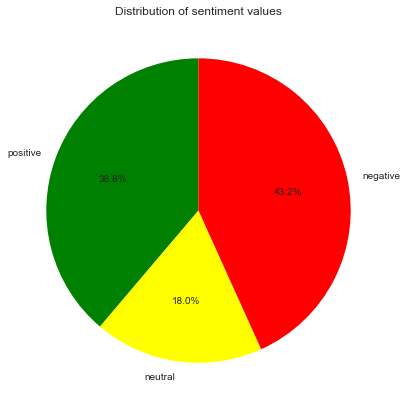

In [10]:
sentiments = [get_sentiment(polarity)
              for polarity in sentiment_df['Polarity']]

sentiment_count_list = np.array([sentiments.count(
    'positive'), sentiments.count('neutral'), sentiments.count('negative')])

classes = ['positive', 'neutral', 'negative']
colors = ['green', 'yellow', 'red']
plt.figure(figsize=(7,7))
plt.pie(sentiment_count_list, labels=classes, autopct='%1.1f%%',startangle=90, colors=colors)
plt.title('Distribution of sentiment values')

print('total positive: {}'.format(sentiments.count('positive')))

print('total neutral: {}'.format(sentiments.count('neutral')))

print('total negative: {}'.format(sentiments.count('negative')))

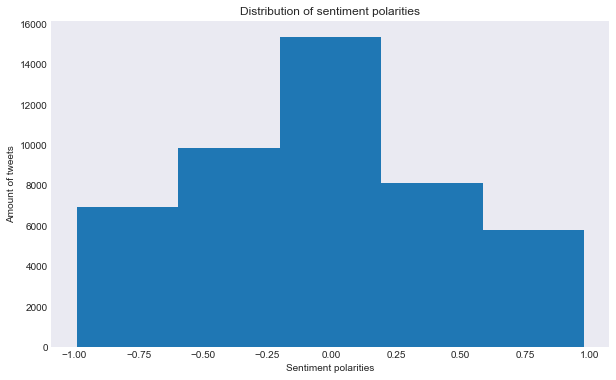

In [11]:
sentiment_df['Polarity'].plot.hist(bins=5, figsize=(10, 6), title='Distribution of sentiment polarities')
plt.xlabel('Sentiment polarities')
plt.ylabel('Amount of tweets')
plt.show()

Total tweets with climate change keyword: 39099
Total tweets with global warming keyword: 6727
Total tweets with Global warming & Climate change as keyword: 326


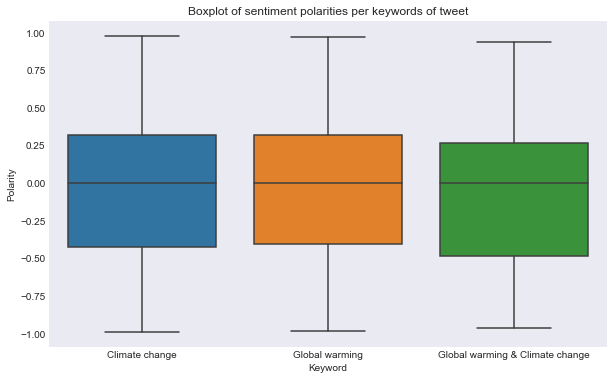

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=sentiment_df['Keyword'], y=sentiment_df['Polarity'])
plt.title('Boxplot of sentiment polarities per keywords of tweet')
total_cc = len(sentiment_df[sentiment_df['Keyword']=='Climate change'])
total_gw = len(sentiment_df[sentiment_df['Keyword']=='Global warming'])
total_ccgw = len(sentiment_df[sentiment_df['Keyword']=='Global warming & Climate change'])

print('Total tweets with climate change keyword: ' + str(total_cc))
print('Total tweets with global warming keyword: ' + str(total_gw))
print('Total tweets with Global warming & Climate change as keyword: ' + str(total_ccgw))


## Implementing machine learning classifiers

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.features.pca import PCADecomposition

### Divide into training and test sets
We create our feature and label sets for training and testing using sklearn's train_test_split. 80% of the data will go to training sets and 20% will go to the testing sets. The method shuffles the data in a random order to make sure the sets are not unbalanced.

In [14]:
from sklearn.model_selection import train_test_split

# Extract features from df
features = sentiment_df['Tweet']

# Extract labels from df
labels = sentiment_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print('Training set contains: '+str(len(X_train))+ ' samples')
print('Testing set contains: '+str(len(X_test))+ ' samples')

Training set contains: 36921 samples
Testing set contains: 9231 samples


The next graph shows us how many instances of each class/label there are in the training set. We can see that the "neutral" class has the least instances so the prediction results of this class might be slightly more inacurate.

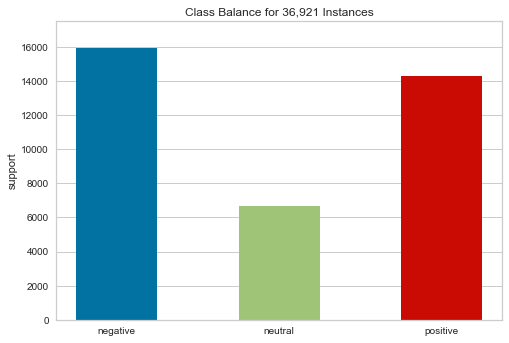

In [15]:
class_balance = ClassBalance(labels=['negative', 'neutral', 'positive'])
class_balance.fit(y_train) 
class_balance.show()


### Preparing pipeline variables
Setup of tokenizers (converting 1 text object to a list of text objects)
and vectorizers

In [16]:
count_vec = CountVectorizer(strip_accents=None, lowercase=False, 
                            preprocessor = None)
tfidf = TfidfTransformer()

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Testing tokenizers

In [17]:
sample_tweet = 'Hi i think global warming is awesome. What about you?'

token_list = tokenizer(sample_tweet)

porter_list =tokenizer_porter(sample_tweet)

In [18]:
count_vec.fit(token_list)
print('With normal tokenizer:')
count_vec.vocabulary_

With normal tokenizer:


{'Hi': 0,
 'think': 6,
 'global': 4,
 'warming': 7,
 'is': 5,
 'awesome': 3,
 'What': 1,
 'about': 2,
 'you': 8}

In [19]:
count_vec.fit(porter_list)
print('With porter tokenizer (stemmer):')
count_vec.vocabulary_

With porter tokenizer (stemmer):


{'Hi': 0,
 'think': 5,
 'global': 3,
 'warm': 6,
 'is': 4,
 'awesome': 2,
 'what': 7,
 'about': 1,
 'you': 8}

### Implementing Logistic regression
One of the least complicated classifiers. Based on linear regression but adapted to predict classes instead of labels (Has good performance on both small and large datasets)

In [20]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', LogisticRegression(random_state=1))])

param_grid_lr ={
                'vect__ngram_range': [(1,1),(1,2)],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
grid_lr = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=150,
                             verbose=1, cv=7, n_jobs=2, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print()

Fitting 7 folds for each of 150 candidates, totalling 1050 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 20.7min


In [ ]:
print('Best parameters: ', grid_lr.best_params_)

#Create classifier based on best parameters
lr = grid_lr.best_estimator_

#Fit the data and predict the classes
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(lr.score(X_test, y_test)*100))

### Implementing Multinomial Naive Bayes
Based on Bayes theorem. Predicts the probability of an output based on combination of given parameters

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                         ('clf', MultinomialNB())])

param_grid_mnb = {
                  'vect__ngram_range': [(1,1), (1,2), (1,3)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
grid_mnb = RandomizedSearchCV(mnb_pipeline, param_grid_mnb, n_iter=60,
                              cv=5, verbose=1, n_jobs=2, scoring='accuracy')
grid_mnb.fit(X_train, y_train)
print()

In [ ]:
print('Best parameters: ',grid_mnb.best_params_)

#Create classifier based on best parameters
mnb = grid_mnb.best_estimator_

#Fit the data and predict the classes
mnb.fit(X_train, y_train)
predictions_mnb = mnb.predict(X_test)

print('\nThe Multinomial Naive Bayes classifier has reached an accuracy of: {:.2f}% \n'
      .format(mnb.score(X_test, y_test)*100))

### Implementing Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', SVC(random_state=1))])

param_grid_svm = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

grid_svc = RandomizedSearchCV(svc_pipeline, param_grid_svm, n_iter=60, 
                              cv=5, verbose=1, n_jobs=2, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print()

In [ ]:
print('Best parameters: ', grid_svc.best_params_)
#Create classifier based on best parameters
svm = grid_svc.best_estimator_

#Fit the data and predict the classes
svm_fit = svm.fit(X_train, y_train)
predictions_svm = svm.predict(X_test)

print('\nThe Support Vector classifier has reached an accuracy of: {:.2f}% \n'
      .format(svm.score(X_test, y_test)*100))

### Implementing decision tree
Tries to determin the class/label of a datapoint based on sequential conditions

In [ ]:
from sklearn import tree

In [ ]:
dt_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', tree.DecisionTreeClassifier(random_state=1))])

param_grid_dt = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__max_depth': np.arange(1, 100),
                  'clf__max_features': np.arange(1, 50),
                  'clf__min_samples_leaf': np.arange(1, 50),
                  'clf__criterion':['gini','entropy']
                 }

grid_dt = RandomizedSearchCV(dt_pipeline, param_grid_dt, n_iter=70, 
                              cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print()

In [ ]:
print(grid_dt.best_params_)
#Create classifier based on best parameters
dt = grid_dt.best_estimator_

#Fit the data and predict the classes
dt.fit(X_train, y_train)
predictions_dt = dt.predict(X_test)
print('\nThe decision tree classifier has reached an accuracy of: {:.2f}% \n'
      .format(dt.score(X_test, y_test)*100))

### Implementing Random Forest
Combination of many random decision trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', RandomForestClassifier(random_state=1))])

param_grid_rf = {
                 'vect__ngram_range': [(1,1),(1,2), (1,3)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [500, 750, 1000, 1500],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 64, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

grid_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf,
                             cv=5, n_iter=100 , verbose=1, n_jobs=2, 
                             scoring='accuracy')

grid_rf.fit(X_train, y_train)
print()

In [ ]:
print(grid_rf.best_params_)
#Create classifier based on best parameters
rf = grid_rf.best_estimator_

#Fit the data and predict the classes
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)
print('\nThe Random Forest classifier has reached an accuracy of: {:.2f}% \n'
      .format(rf.score(X_test, y_test)*100))

### Testing XGBoost

In [ ]:
import xgboost

In [ ]:
xgb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', xgboost.XGBClassifier())])

param_grid_xgb = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__eta'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                  'clf__max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  'clf__min_child_weight' : [ 1, 3, 5, 7 ],
                  'clf__gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                  'clf__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
                 }

grid_xgb = RandomizedSearchCV(dt_pipeline, param_grid_dt, n_iter=50, 
                              cv=7, verbose=1, n_jobs=2, scoring='neg_log_loss')
grid_xgb.fit(X_train, y_train)
print()

In [ ]:
print(grid_xgb.best_params_)
#Create classifier based on best parameters
xgb = grid_xgb.best_estimator_

#Fit the data and predict the classes
xgb.fit(X_train, y_train)
predictions_xgb = dt.predict(X_test)
print('\nThe XGBoost  classifier has reached an accuracy of: {:.2f}% \n'
      .format(xgb.score(X_test, y_test)*100))

## Comparing clasiffier results

### Confusion matrices
Matrix that shows the true and false predictions per class

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ConfusionMatrix(model=mnb, classes=classes, ax=ax[0,0]),
    ConfusionMatrix(model=lr, classes=classes, ax=ax[0,1]),
    ConfusionMatrix(model=svm, classes=classes, ax=ax[1,0]),
    ConfusionMatrix(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()


### ROCAUC curve
tradeoff between the model’s sensitivity and specificity

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15), tight_layout=True)

visualgrid = [
    ROCAUC(model=mnb, classes=classes, ax=ax[0,0], micro=False, macro=False),
    ROCAUC(model=lr, classes=classes, ax=ax[0,1], micro=False, macro=False),
    ROCAUC(model=svm, classes=classes, ax=ax[1,0], micro=False, macro=False),
    ROCAUC(model=rf, classes=classes, ax=ax[1,1], micro=False, macro=False)
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()


### Classification reports
Report on the accuracy of the classifier

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ClassificationReport(model=mnb, classes=classes, ax=ax[0,0]),
    ClassificationReport(model=lr, classes=classes, ax=ax[0,1]),
    ClassificationReport(model=svm, classes=classes, ax=ax[1,0]),
    ClassificationReport(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()
